### Jeff Rutledge (Data Science Part-time Course) - Classification Assignment
- The main goal of this assignment is to check in on your ability to access, load, explore, and make predictions using classification models

The assignment requires:
- Locate a dataset on Kaggle, NYC Open Data, UCI Machine Learning Repository, or other resource that contains data that can be addressed through a classification task
- Load and explore the data for missing values and perform a brief EDA
- Frame and state the classification problem
- Split your data into train and test sets
- Implement a DummyClassifier, KNeighborsClassifier, and LogisticRegression model.
- Improve the models by performing a GridSearchCV for n_neighbors and C parameters respectively. Include a scale transformation in your pipeline for KNN and a PolynomialFeatures step in the Logistic model.
- Discuss the outcome of your classifiers using the classification_report. Which did the best? Do you prefer a recall or a precision oriented model? Why?

EXTRA:
- Include SGDClassifier
- Incorporate AUC and ROC curves

#### Dataset selected - Titanic
- I selected the titanic dataset
- The project's goal is to create a classifier model that best predicts whether passengers survive the titanic sinking.

#### Titanic dataset features include:
- Survived - whether passenger survived (yes = 1, no = 0)
- Pclass - ticket class (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
- Sex - passenger gender
- Age - passenger age
- SibSp - number of siblings/spouses aboard Titanic
- Parch - number of parents/children aboard Titanic
- Fare - passenger fare
- Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
# Import Python Libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Import dataset
titanic = pd.read_csv('Data/titanic_clean.csv')

#### Conduct exploratory data analysis (EDA)
- The titanic dataset I downloaded was largely clean.  Therefore, there are few "cleaning" steps. 

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 10 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            712 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Fare           712 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 55.7+ KB


In [4]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [6]:
# Double-checking to ensure all features have 712 entries total
print(titanic.Survived.value_counts())
print(titanic.Pclass.value_counts())
print(titanic.Sex.value_counts())
print(titanic.Embarked.value_counts())

0    424
1    288
Name: Survived, dtype: int64
3    355
1    184
2    173
Name: Pclass, dtype: int64
male      453
female    259
Name: Sex, dtype: int64
S    554
C    130
Q     28
Name: Embarked, dtype: int64


Text(0.5,1,'Embark Port')

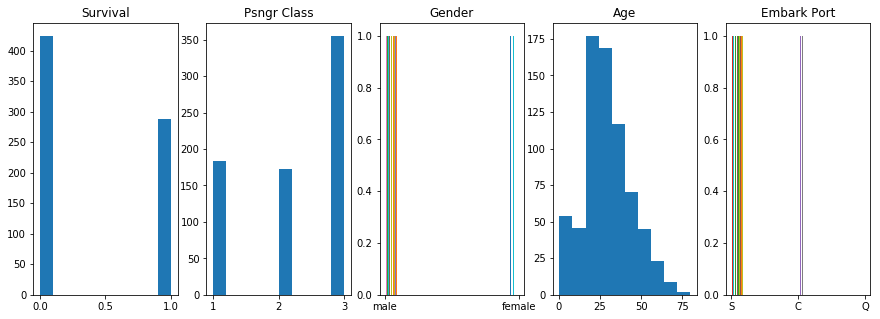

In [7]:
# We view the features' distributions graphically
plt.figure(figsize = (15, 5))
plt.subplot(1, 5, 1)
plt.hist(titanic.Survived)
plt.title('Survival')
plt.subplot(1, 5, 2)
plt.hist(titanic.Pclass)
plt.title('Psngr Class')
plt.subplot(1, 5, 3)
plt.hist(titanic.Sex)
plt.title('Gender')
plt.subplot(1, 5, 4)
plt.hist(titanic.Age)
plt.title('Age')
plt.subplot(1, 5, 5)
plt.hist(titanic.Embarked)
plt.title('Embark Port')

#### We now need to transform both the "Sex" (passenger gender) and "Embarked" (passenger embarkation port) features so that we can use them in our models.  For "Sex", we will create a new feature - "Female" - by mapping passengers' gender in "Sex" into a "1" or "0" data item (1 = female; 0 = not female, or male).  For "Embarked", we will create a new dummy variable.

In [8]:
titanic['Female'] = titanic['Sex'].map(lambda x: 1 if x == 'female' else 0)

In [9]:
Embarked_dummies = pd.get_dummies(titanic.Embarked)

In [10]:
Embarked_dummies.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [11]:
# We add the "Embarked" city dummy variables to our original "titanic" dataframe, and rename it "titanic1"
titanic1 = pd.concat([titanic, Embarked_dummies], axis=1)

In [12]:
titanic1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Female,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,0,0,1


### Implement Logistic Regression Model
- We now implement our Logistic Regression classification model
- We define the independent variable(s) = X
- We define the dependent variable, or "target" variable = y

#### Note that we examined all combinations of independent variables for "X".  Using all of the Pclass, Age, Female, and Embarking City produced the best model score.

In [13]:
#X = titanic1['Pclass'].values.reshape(-1,1)
X = titanic1[['Pclass', 'Age', 'Female', 'C', 'Q', 'S']]
y = titanic1['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
# Instantiate and fit the model
titanic_clf = LogisticRegression()
titanic_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
titanic_clf.score(X, y)

0.7935393258426966

### Evaluating the Classification Model via Classification Report
- Precision - ratio of correctly predicted positive observations to the total number of predicted positive observations.  (High precision ~= a low false positive rate.)
- Recall - ratio of correctly predicted positive observations to the total number of observations.
- F1 score - harmonic mean of Precision and Recall scores.

In [16]:
titanic_prediction = titanic_clf.predict(X_test)
print(classification_report(y_test, titanic_prediction))

             precision    recall  f1-score   support

          0       0.84      0.79      0.82       110
          1       0.69      0.76      0.73        68

avg / total       0.79      0.78      0.78       178



In [17]:
confusion_matrix(y_test, titanic_prediction)

array([[87, 23],
       [16, 52]])

#### We now conduct a grid search on our Logistic Rgression model

In [18]:
# This code block contains notes only 
# titanic_params = {'polynomialfeatures__degree': [i for i in range(1, 6)], 'logisticregression__C': [0.1, 1, 5, 10, 
#                  20, 50, 100]}

In [19]:
titanic_params = {'C': [0.1, 1, 5, 10, 20, 50, 100]}

In [20]:
titanic_grid_clf = LogisticRegression()

In [21]:
titanic_grid = GridSearchCV(titanic_grid_clf, param_grid=titanic_params, cv = 10)

In [22]:
titanic_grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
titanic_grid.score(X, y)

0.797752808988764

In [24]:
titanic_grid_pred = titanic_grid.predict(X_test)
print(classification_report(y_test, titanic_grid_pred))

             precision    recall  f1-score   support

          0       0.86      0.79      0.82       110
          1       0.70      0.79      0.74        68

avg / total       0.80      0.79      0.79       178



#### Logistic Regression model efficacy versis Grid Search efficacy
- The Grid Search model score is slightly better than the original Logistic Regression Score.  However, the Grid Search's classification report tells us that the Grid Search run produces slightly less efficacy as compared with the original Logistic Regression model.  Note the Grid Search's Precision and Recall scores are lower than our Logistic Regression model's Precision and Recall scores.

### Implement Dummy Classifier Model

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
titanic_dum_class = DummyClassifier(strategy='most_frequent')
titanic_dum_class.fit(X_train, y_train)
titanic_dum_pred = titanic_dum_class.predict(X_train)
print(confusion_matrix(y_train, titanic_dum_pred))
print(classification_report(y_train, titanic_dum_pred))

[[314   0]
 [220   0]]
             precision    recall  f1-score   support

          0       0.59      1.00      0.74       314
          1       0.00      0.00      0.00       220

avg / total       0.35      0.59      0.44       534



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
titanic_dum_class.score(X, y)

0.5955056179775281

In [28]:
baseline = 1-np.mean(titanic1['Survived'])

In [29]:
baseline

0.5955056179775281

#### The Dummy Classifier model's results suggest this model's performance is weak as compared to our Logistic Regression model.

### Implement KNeighborClassifier Model
- Prior to instantiating and fitting the KNN model, we have to scale our independent variables (see below)

In [30]:
# Define our independent (X) and dependent (y) variables 
X = titanic1[['Pclass', 'Age', 'Female', 'C', 'Q', 'S']]
y = titanic1['Survived']

In [31]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
SX = ss.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(SX, y)

In [33]:
# instantiate two KNN models: one for 5 closest neighbors, the second for 20 closest neighbors
knn_model_5 = KNeighborsClassifier(n_neighbors = 5)
knn_model_20 = KNeighborsClassifier(n_neighbors = 20)

In [34]:
# fit the KNN instances
knn_model_5.fit(X_train, y_train)
knn_model_20.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [35]:
# run predictions for both the 5- and 20-nearest KNN instances 
knn_pred_5 = knn_model_5.predict(X_test)
knn_pred_20 = knn_model_20.predict(X_test)

In [36]:
print(classification_report(y_test, knn_pred_5))
print(classification_report(y_test, knn_pred_20))

             precision    recall  f1-score   support

          0       0.81      0.81      0.81       105
          1       0.73      0.73      0.73        73

avg / total       0.78      0.78      0.78       178

             precision    recall  f1-score   support

          0       0.76      0.87      0.81       105
          1       0.76      0.62      0.68        73

avg / total       0.76      0.76      0.76       178



#### Our KNN Model produces results similar to our Logistic Regression Model.

### Analysis of Results and Model Performance

#### Logistic Regression Model
- Our Logistic Regression model produced strong results.  The model's score was 79%.
- The Log-Reg model's Grid Search classification report showed strong results, but the model's efficacy was somewhat less impressive than the original Logistic Regression model.

#### Dummy Classifier Model
- Our Dummy Classifier model produced the weakest scores throughout.

#### KNN/KNearest Model
- Our KNearestNeighbor model produced the strongest results overall.  